In [1]:
import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

Q1.a What global schema (post-pushdown was detected)?

In [14]:
hyper_path = 'data/job/job_hyper.json'
nohyper_path = 'data/job/job_global.json'

In [15]:
job_hyper = json.load(open(hyper_path))
job_nohyper = json.load(open(nohyper_path))

In [22]:
# check for each how many different schemas exist and return dict with counts
def in_schema_count(job):
    c = {'normal': {}, 'general': {}}
    for r in job['requests']:
        for k in ['normal', 'general']:
            schema = r['input_schemas'][k]
            if schema not in c[k]:
                c[k][schema] = 1
            else:
                c[k][schema] += 1
    return c

In [23]:
in_schema_count(job_hyper)

{'normal': {'Tuple[i64,str,i64,i64,i64,i64,f64,i64,f64,f64,f64]': 177,
  'Tuple[i64,_Constant[str,value="\'PA (1)\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64]': 1,
  'Tuple[i64,_Constant[str,value="\'WN\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64]': 1,
  'Tuple[i64,_Constant[str,value="\'TW\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64]': 2,
  'Tuple[i64,_Constant[str,value="\'HP\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64]': 1,
  'Tuple[i64,str,i64,i64,i64,f64,f64,f64,null,null,null,null,null]': 14,
  'Tuple[i64,_Constant[str,value="\'DL\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64]': 1,
  'Tuple[i64,_Constant[str,value="\'UA\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64]': 3,
  'Tuple[i64,i64,_Constant[str,value="\'UA\'"],i64,i64,i64,i64,f64,i64,f64,f64,f64,null,null,null,null,null]': 1,
  'Tuple[i64,str,i64,i64,i64,f64,f64,f64,Option[f64],Option[f64],Option[f64],Option[f64],Option[f64]]': 189,
  'Tuple[i64,_Constant[str,value="\'AA\'"],i64,i64,i64,f64,f64,f64,Option[f64],Option[f64],Option[f64],Option[f64],Opti

In [24]:
in_schema_count(job_nohyper)

{'normal': {'Tuple[i64,i64,i64,str,i64,i64,i64,i64,f64,i64,f64,f64,f64,null,null,null,null,null]': 410},
 'general': {'Tuple[Option[i64],Option[i64],Option[i64],Option[str],Option[i64],Option[i64],Option[i64],Option[i64],Option[f64],Option[i64],Option[f64],Option[f64],Option[f64],Option[str],Option[str],Option[str],Option[str],Option[str]]': 410}}

In [25]:
# hyper schema:  Tuple[i64,str,i64,i64,i64,i64,f64,i64,f64,f64,f64]
# global schema: Tuple[i64,i64,i64,str,i64,i64,i64,i64,f64,i64,f64,f64,f64,null,null,null,null,null]

It looks like the null-check is not performed correctly for the global version?!

In [38]:
schema = 'Tuple[i64,str,i64,i64,i64,i64,f64,i64,f64,f64,f64]'

print('hyper: {}'.format(job_hyper['requests'][0]['input_paths_taken']))
print('global: {}'.format(job_nohyper['requests'][0]['input_paths_taken']))
#, job_nohyper['requests'][0]



hyper: {'normal': 417694, 'general': 3301, 'fallback': 0, 'unresolved': 0}
global: {'normal': 385612, 'general': 9564, 'fallback': 0, 'unresolved': 0}


In [42]:
job_hyper['requests'][0]['requestId'], job_hyper['tasks'][0]

('2121837b-6718-4be8-854c-3df21cc0c9f6',
 {'container': {'reused': True,
   'requestId': '2121837b-6718-4be8-854c-3df21cc0c9f6',
   'uuid': '3e003c16-a30c-4e5c-9baf-f179055e0825',
   'msRemaining': 595672,
   'requestsServed': 2,
   'startTimestamp': 1675315354168963745,
   'deadlineTimestamp': 1675316121040000000},
  'invoked_containers': [],
  'log': '[2023-02-02 05:24:54.043] [Lambda worker] [info] current worker settings: {"numThreads":3, "normalBufferSize":131072000, "exceptionBufferSize":131072000, "hashBufferSize":8388608, "spillRootURI":"s3://tuplex-leonhard/scratch/flights-exp/spill_folder/lam374/0", "runTimeMemory":134217728, "runTimeMemoryDefaultBlockSize":4194304, "allowNumericTypeUnification":false, "useInterpreterOnly":false, "useCompiledGeneralPath":true, "opportuneGeneralPathCompilation":true, "useOptimizer":true, "sampleLimitCount":10000, "useFilterPromotion":false, "useConstantFolding":true, "normalCaseThreshold":0.9, "exceptionSerializationMode":2, "s3PreCacheSize":0

In [21]:
job_hyper['requests'][0]['input_schemas'], job_hyper['requests'][0]['output_schemas']

({'normal': 'Tuple[i64,str,i64,i64,i64,i64,f64,i64,f64,f64,f64]',
  'general': 'Tuple[Option[i64],Option[i64],Option[i64],Option[str],Option[i64],Option[i64],Option[i64],Option[i64],Option[f64],Option[i64],Option[f64],Option[f64],Option[f64],Option[str],Option[str],Option[str],Option[str],Option[str]]'},
 {'normal': 'Tuple[str]', 'general': 'Tuple[str]'})

Q1.b What individual schemas did individial Lambdas specialize to?

In [2]:
# paths = glob.glob('../results_hyper/*.txt')
paths = glob.glob('data/results_hyper/badparse-fmt/*.txt')
paths = glob.glob('data/results_hyper/internal-fmt/*.txt')

In [3]:
path = paths[0]
path

'data/results_hyper/internal-fmt/flights-hyper-run-5.txt'

In [4]:
parts = os.path.basename(path).split('-')
parts[:-1]

['flights', 'hyper', 'run']

In [5]:
def extract_row(path):
    with open(path) as fp:
        lines = fp.readlines()

        sel = list(filter(lambda line: line.startswith('{"startupTime":'), lines))
        row = json.loads(sel[0])
        parts = os.path.basename(path).split('-')
        mode = '-'.join([p for p in parts[:-1] if p not in ['flights', 'run']])
        run = parts[-1]
        run = int(run.replace('.txt', ''))
        row['mode'] = mode
        row['run'] = run
        row['path'] = path

        sel = list(filter(lambda line: 'LAMBDA compute took' in line, lines))[0]
        cost = float(sel[sel.find('cost $')+6:].strip())

        row['cost'] = cost

        return row

In [125]:
rows = []
for path in paths:
    rows.append(extract_row(path))
    
df = pd.DataFrame(rows)

In [126]:
df.groupby('mode').agg(['mean', 'std']).reset_index()

/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_37400/3645649352.py:1: FutureWarning: ['path'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('mode').agg(['mean', 'std']).reset_index()


mode startupTime              jobTime            run            \
                       mean       std       mean       std mean       std   
0         hyper    0.198920  0.019765  16.637212  0.229461  4.0  2.160247   
1    hyper-nocf    0.195543  0.012122  16.413572  0.124237  4.0  2.160247   
2       nohyper    0.199423  0.023983  15.374068  1.612362  4.0  2.160247   
3  nohyper-nocf    0.202687  0.012385  16.021030  0.266555  4.0  2.160247   

       cost            
       mean       std  
0  0.342857  0.004880  
1  0.341429  0.003780  
2  0.308571  0.058146  
3  0.282857  0.004880

In [127]:
#speedup
63.819428 / 47.310272

1.348955000723733

In [128]:
1.0 - 0.592 / 0.932 

0.36480686695278974

In [129]:
# maybe use different sampling modes?

In [130]:
# generate the table from path info

In [131]:
test = 'LAMBDA Stage output: 202449065 rows, 238590 exceptions'
nums = [int(n) for n in re.findall('(\d+)', test)]
output_rows, exceptions = nums

In [132]:
def extract_path_stats_row(path):
    print(path)
    with open(path) as fp:
        lines = fp.readlines()
        needle = 'LAMBDA paths input rows took:'
        sel = list(filter(lambda line: needle in line, lines))[0]

        sel = sel[sel.find('normal:'):]
        print(sel)
        _, normal, _, general, _, interpreter, = sel.strip().split(' ')


        # fetch if there are any unresolved rows
        # format is something like LAMBDA Stage output: 202449065 rows, 238590 exceptions
        needle = 'LAMBDA Stage output:'
        sel = list(filter(lambda line: needle in line, lines))[0]

        nums = [int(n) for n in re.findall('(\d+)', test)]
        output_rows, exceptions = nums
        
        
        row = {'normal' : int(normal),
               'general': int(general),
               'interpreter' : int(interpreter),
               'unresolved': exceptions,
               'total_out': output_rows}

        _, mode, _, run = os.path.basename(path).split('-')
        row['mode'] = mode
    return row

In [133]:
df_rows = pd.DataFrame([extract_path_stats_row('data/results_hyper/badparse-fmt/flights-hyper-run-1.txt'),
                       extract_path_stats_row('data/results_hyper/badparse-fmt/flights-nohyper-run-1.txt')])

data/results_hyper/badparse-fmt/flights-hyper-run-1.txt
normal: 187855165 general: 14593900 interpreter: 0

data/results_hyper/badparse-fmt/flights-nohyper-run-1.txt
normal: 175552445 general: 27135210 interpreter: 0



In [109]:
df_rows

,normal,general,interpreter,unresolved,total_out,mode
0,187855165,14593900,0,238590,202449065,hyper
1,175552445,27135210,0,238590,202449065,nohyper


In [110]:
df_rows.style.format(thousands=",")
print(df_rows[['mode', 'normal', 'general', 'unresolved']].to_latex(index=None))

\begin{tabular}{lrrr}
\toprule
    mode &     normal &   general &  unresolved \\
\midrule
   hyper &  187855165 &  14593900 &      238590 \\
 nohyper &  175552445 &  27135210 &      238590 \\
\bottomrule
\end{tabular}



/var/folders/l7/8zgzcszx7z5gk7kk92f6nc1c0000gn/T/ipykernel_37400/910385977.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_rows[['mode', 'normal', 'general', 'unresolved']].to_latex(index=None))


## paper figure

In [111]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.path import *

In [112]:
# adjust settings for final paper (colors & Co)
def adjust_settings():
    # make nice looking plot

    sns.set_style('whitegrid')
    sns.set_context('poster')  # Everything is larger

    # matplotlib.rcParams['font.family'] = "serif"

    # red 900c3f

    # 48A70B
    sns.set_palette(
        [[.22, .52, .71], [.53, .80, .81], [144 / 255., 12 / 255, 63 / 255.], [67 / 255., 135 / 255., 107 / 255.],
         [248 / 255., 194 / 255., 145 / 255.]])

    matplotlib.rc('font', family='serif', size=9)
    matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
    matplotlib.rc('text', usetex=True)
    matplotlib.rc('legend', fontsize=8)
    matplotlib.rc('figure', figsize=(2.5, 1.4))
    matplotlib.rc('axes', linewidth=0.5)
    matplotlib.rc('lines', linewidth=0.5)

In [113]:
total = df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[0].sum()
total

202687655

In [114]:
assert total == df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[1].sum()

AssertionError: 

In [115]:
total - df_rows[['normal', 'general', 'interpreter', 'unresolved']].iloc[1].sum()

-238590

In [116]:
df_rows = df_rows.sort_values(by='normal', ascending=True).reset_index(drop=True)

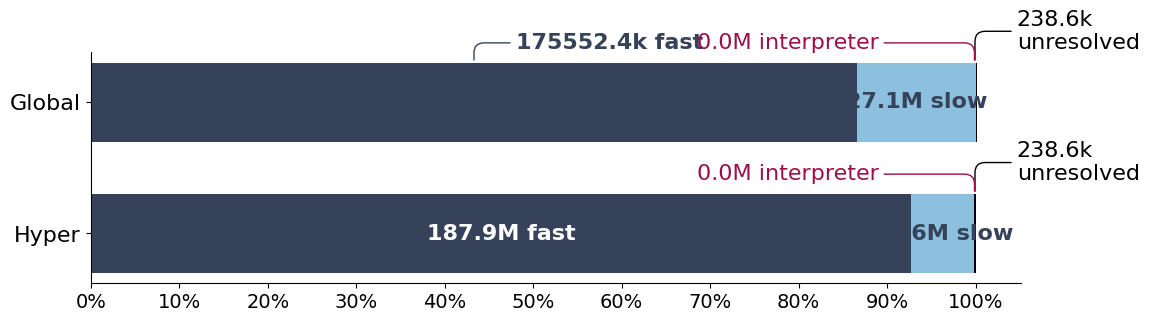

In [118]:
rel = 0
h = 0.6
plt.figure(figsize=(12, 3))
ax = plt.gca()
# https://matplotlib.org/stable/tutorials/text/annotations.html#sphx-glr-tutorials-text-annotations-py
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/annotation_demo.html
n_col = np.array([53, 66, 89]) / 255.0#sns.color_palette()[0]
g_col = np.array([140, 192, 222]) / 255.0 #sns.color_palette()[1]
i_col = np.array([156, 15, 72]) / 255.0 #sns.color_palette()[2]

tg_col = n_col
yq = np.arange(len(df_rows))[::-1]
plt.barh(yq, df_rows['normal'] / total, h, left=rel, color=n_col)

m = rel + df_rows['normal'] / total * .5
ax.text(m[1], 0, '{:.1f}M fast'.format(df_rows['normal'].iloc[1] / 10**6),
        va='center', ha='center', fontsize=16, color='w', fontweight='bold',)

rel += df_rows['normal'] / total
plt.barh(yq, df_rows['general'] / total, h, left=rel, color=g_col)

m = rel + df_rows['general'] / total * .5
ax.text(m[0], 1, '{:.1f}M slow'.format(df_rows['general'].iloc[0] / 10**6),
        va='center', ha='center', fontsize=16, color=tg_col, fontweight='bold',)
ax.text(m[1], 0, '{:.1f}M slow'.format(df_rows['general'].iloc[1] / 10**6),
        va='center', ha='center', fontsize=16, color=tg_col, fontweight='bold',)


rel += df_rows['general'] / total
plt.barh(yq, df_rows['interpreter'] / total, h, left=rel, color=i_col)
rel += df_rows['interpreter'] / total
plt.barh(yq, df_rows['unresolved'] / total, h, left=rel, color='k')
xq = np.arange(0, 1.1, 0.1)


ax.annotate(
    '{:.1f}k fast'.format(df_rows['normal'].iloc[0] / 1000.0),
    xy=(df_rows['normal'].iloc[0] / total * 0.5, 1 + h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points', color=n_col, fontweight='bold',
    arrowprops=dict(arrowstyle="-", color=n_col,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}k\nunresolved'.format(df_rows['unresolved'].iloc[0] / 1000.0),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total * 0.5, 1 + h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))
ax.annotate(
    '{:.1f}k\nunresolved'.format(df_rows['unresolved'].iloc[0] / 1000.0),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total * 0.5, h/2), xycoords='data',
    xytext=(30, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-",
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}M interpreter'.format(df_rows['interpreter'].iloc[0] / 10**6),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total - df_rows['interpreter'].iloc[0] / total * 0.5, 1 + h/2),
    xycoords='data', color=i_col,
    xytext=(-200, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-", color=i_col, 
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

ax.annotate(
    '{:.1f}M interpreter'.format(df_rows['interpreter'].iloc[1] / 10**6),
    xy=(1.0 - df_rows['unresolved'].iloc[0] / total - df_rows['interpreter'].iloc[1] / total * 0.5, h/2),
    xycoords='data', color=i_col,
    xytext=(-200, 10), fontsize=16, textcoords='offset points',
    arrowprops=dict(arrowstyle="-", color=i_col,
                    connectionstyle="angle,angleA=0,angleB=90,rad=10"))

plt.xticks(xq, ['{}%'.format(int(x * 100)) for x in xq], fontsize=14)
plt.yticks([0, 1], ['Hyper', 'Global'], fontsize=16)
sns.despine()

plt.savefig('workshop_path_breakdown.pdf', transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)

In [140]:
print(m)

0    0.444679
1    0.850303
dtype: float64


In [37]:
help(plt.barh)

Help on function barh in module matplotlib.pyplot:

barh(y, width, height=0.8, left=None, *, align='center', **kwargs)
    Make a horizontal bar plot.
    
    The bars are positioned at *y* with the given *align*\ment. Their
    dimensions are given by *width* and *height*. The horizontal baseline
    is *left* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    y : float or array-like
        The y coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    width : float or array-like
        The width(s) of the bars.
    
    height : float or array-like, default: 0.8
        The heights of the bars.
    
    left : float or array-like, default: 0
        The x coordinates of the left sides of the bars.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the base to the *y* coordinates*:
 

In [196]:
df_rows

,normal,general,interpreter,unresolved,mode
0,448620,179364496,22635949,238590,nohyper
1,149930703,44830574,7687788,238590,hyper


In [197]:
179364496 / total

0.8849305400469506

In [198]:
448620 / total

0.0022133563092434022